In [14]:
import sys, os

if "google.colab" in sys.modules:
    !apt update > /dev/null 2>&1 && apt install libeigen3-dev > /dev/null 2>&1
    !git clone https://github.com/kharitonov-ivan/multi-object-tracking-in-python.git > /dev/null 2>&1
    !cd multi-object-tracking-in-python && python -m pip install -e . > /dev/null 2>&1
    sys.path.append("/content/multi-object-tracking-in-python")

import scipy, numpy as np, matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

# Introduction

Object tracking is essential for understanding and predicting the behavior of dynamic systems in various domains. It uses data from sensors to estimate the states of surrounding objects and associate them with those seen previously. For instance, air traffic control systems track aircraft using radar to ensure safe navigation and collision avoidance. In scientific research, tracking the movement of mice in experiments can provide insights into behavioral patterns or reactions to stimuli. Similarly, autonomous vehicles rely on object tracking to navigate safely by continuously monitoring and responding to the positions and trajectories of nearby objects, like other vehicles, pedestrians, and obstacles.

<img src="https://raw.githubusercontent.com/kharitonov-ivan/multi-object-tracking-in-python/main/images/tutorial/mot.drawio.svg" alt="drawing" width="600"/>


Object tracking is crucial for systems like motion prediction, which relies on historical data and trajectories. However, this process is complex due to several challenges:

*   **Clutter.** This involves erroneous measurements that don't correspond to actual objects. Imperfect object detectors often yield false positives, which are a common part of working with detection systems.
*   **Missed Detections.** Detection algorithms may occasionally skip objects, or objects may become occluded, leading to lapses in tracking.
*   **Measurement Noise.** The data collected from sensors is seldom perfect and often contains noise that can distort measurements.
*   **Association Ambiguities.** It can be difficult to match existing tracks with new measurements, especially when multiple objects are present.
*   **Variable Object Count** The number of objects within the field of view can change as objects appear or disappear, complicating the tracking process.

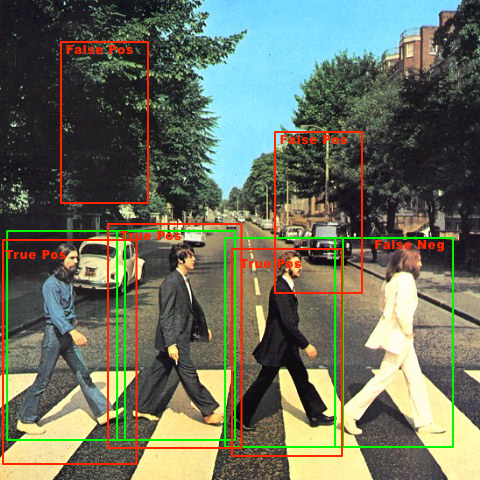


We're going to tackle the multi-object tracking (MOT) algorithm bit by bit. Our approach is model-based, so we're building models for each issue we encounter. The idea is to create models that closely represent reality. If our models are good, they'll help us find solutions.

Of course, there's also the data-driven approach. This means we'd use a lot of data to teach our system how to track objects instead of relying solely on predefined models.

# Single object tracking

In this section, we'll look at a straightforward scenario. We start with a known initial state of the object and aim to track it in a noisy environment. To do this effectively, we introduce several key components: a measurement model to interpret sensor data, a motion model to predict the object's movements, a clutter model to account for extraneous signals, and a missed detection model to handle instances when the object is not observed. These elements help us maintain accurate tracking despite the challenges.

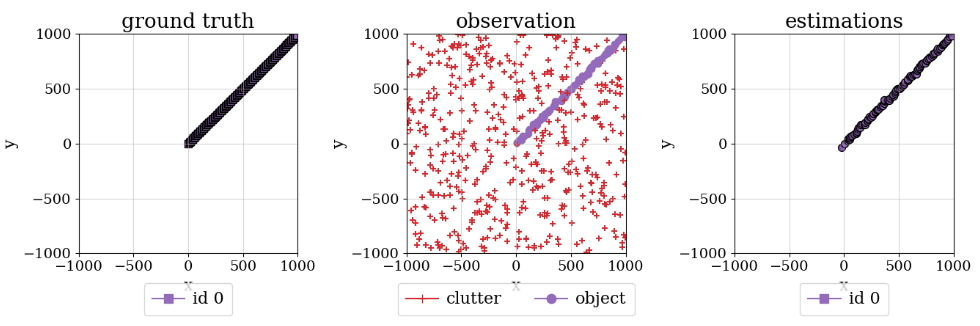

### Motion Model

The motion model defines the transition of an object from its current state to a future state. To account for uncertainties in movement, we introduce random noise, typically modeled as Gaussian. This approach views the object's state as a Markov chain, where the future state depends solely on the current state, independent of past states. The mathematical expression for this concept is:

$$
p(x_{k} | x_{k-1}) = \pi_{k}(x_{k} | x_{k-1})
$$

Here, $p(x_{k} | x_{k-1})$ represents the probability of the object being in state $x_k$ at the next time step, given its current state $x_{k-1}$.

$\pi_{k}$ denotes the transition process, typically described as:

$$
x_{k} = f_{k-1}(x_{k-1}) + q_{k-1}, \quad q_{k-1} \sim N(0, Q_{k-1})
$$

$f_{k-1}$ - the state transition function, predicting the next state based on the current one.

$q_{k-1}$ - the process noise, following normal distribution with zero mean and covariacne $Q_{k-1}$

This leads to the following formulation for $\pi_{k}$:

$$
\pi_{k}(x_{k} | x_{k-1}) = N(x_{k} ; f_{k-1}(x_{k-1}), Q_{k-1})
$$

Common types of motion models include:
- Constant Velocity: The object moves at a steady speed.
- Coordinate Turn: The object turns with a consistent angular velocity.
- Constant Acceleration: The object accelerates at a constant rate.


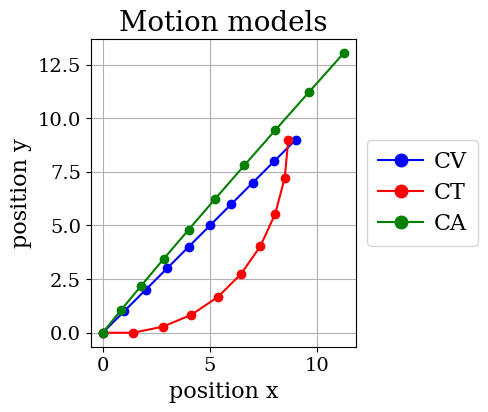

In [15]:
from src.motion_models import ConstantVelocityMotionModel, CoordinateTurnMotionModel, ConstantAccelerationMotionModel

models = {
    "CV": [ConstantVelocityMotionModel(42, 0.1), [0, 0, 1, 1]],  # pos x, pos y, vel x, vel y
    "CT": [CoordinateTurnMotionModel(42, 0.1, 0.1), [0, 0, np.sqrt(2), 0, 0.1]],  # pos x, pos y, vel, angle, angle speed
    "CA": [ConstantAccelerationMotionModel(42, 0.1), [0, 0, 0.8, 1.0, 0.1, 0.1]],  # pos x, pos y, vel x, vel y, acc x, acc y
}  # model name -> [model object(seed, noise params), initial state]

steps, dt = 10, 1.0
history = {key: [val[1]] for key, val in models.items()}
for key in history:
    model = models[key][0]
    for t in range(1, steps):
        next_state = model.f(history[key][t - 1], dt)
        history[key].append(next_state)

plt.figure(figsize=(4, 4))
for key, color in zip(history, ["blue", "red", "green"]):
    plt.plot([x[0] for x in history[key]], [x[1] for x in history[key]], label=key, marker="o", color=color)

plt.gca().set_aspect("equal")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Motion models")
plt.xlabel("position x")
plt.ylabel("position y")
plt.grid(True)
plt.show()

## Measurement model

In state estimation, the states we track and our measurements can differ in nature. For example, while tracking a landmark on a 2D plane, we might measure distance and heading rather than direct coordinates. To connect these measurements with the actual state, we use a transition function.

For instance, we often assume that
$$
o_{k}=h_{k}\left(x_{k}\right)+v_{k}, \quad v_{k} \sim N \left(0, R_{k}\right)
$$
such that
$$
g_{k}\left(o_{k} \mid x_{k}\right)=N\left(o_{k} ; h_{k}\left(x_{k}\right), R_{k}\right)
$$


where

*   $o_k$ - measurement at time $k$
*   $h_k(x_k)$ - expected measurement given state $x$ at time $k$
*   $g_{k}\left(o_{k} \mid x_{k}\right)$ - likelihood of $o_k$ given state $x_k$

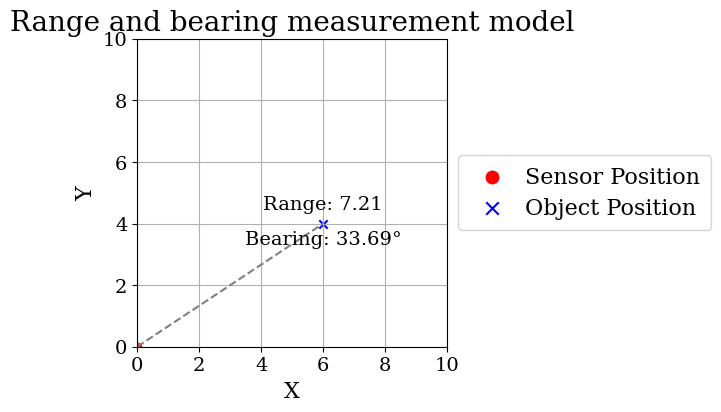

In [16]:
from src.measurement_models import RangeBearingMeasurementModel

sigma_r, sigma_b = 1, np.deg2rad(5)  # Measurement noise standard deviations
sensor_pos = np.array([0, 0])  # Sensor position
model = RangeBearingMeasurementModel(sigma_r, sigma_b, sensor_pos)

state_vector = np.array([6, 4, 0, 0])  # [x, y, velocity_x, velocity_y]
measured_range, measured_bearing = model.h(state_vector)

plt.figure(figsize=(4, 4))
plt.scatter(sensor_pos[0], sensor_pos[1], marker="o", color="red", label="Sensor Position")
plt.scatter(state_vector[0], state_vector[1], marker="x", color="blue", label="Object Position")
plt.plot([sensor_pos[0], state_vector[0]], [sensor_pos[1], state_vector[1]], color="gray", linestyle="--")
plt.annotate(f"Range: {measured_range:.2f}", (state_vector[0], state_vector[1]), textcoords="offset points", xytext=(0, 10), ha="center")
plt.annotate(f"Bearing: {np.rad2deg(measured_bearing):.2f}°", (state_vector[0], state_vector[1]), textcoords="offset points", xytext=(0, -15), ha="center")

plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Range and bearing measurement model")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

## Kalman filtering

Now, let's consider the ideal case with perfect detections and no clutter. However, we can still account for noise in measurements and motion models. Our models have already been defined by us. In this scenario, assuming that the noise in them is additive and Gaussian, this filtering problem can be solved using the Kalman Filter.

The idea is that we represent the object's state as a Gaussian distribution. We can propagate it into the future using a motion model and also transform it into the measurement space.

The concept is that when we receive measurements, we update our state by propagating it with the motion model, and then we consider that the true estimate consists of a combination of the information obtained from the prediction and the measurements.

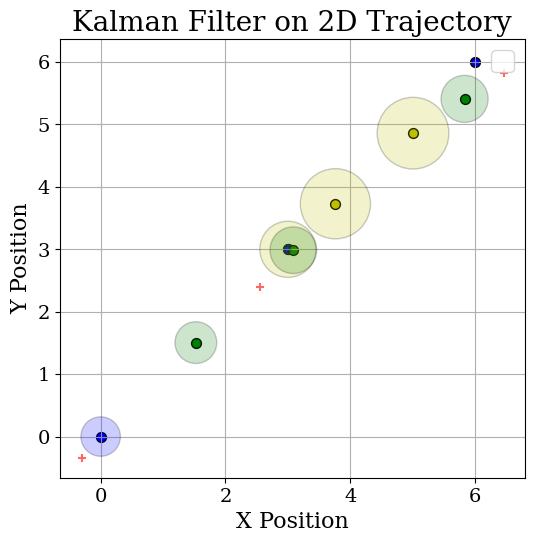

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from src.measurement_models import ConstantVelocityMeasurementModel
from src.common.state import Gaussian
from src.common.gaussian_density import GaussianDensity as gd

motion_model = ConstantVelocityMotionModel(random_state=42, sigma_q=0.1)
measurement_model = ConstantVelocityMeasurementModel(sigma_r=0.5)


# Kalman Filter Predict Step
def predict(state: Gaussian, motion_model, dt):
    F = motion_model.F(state.x, dt)
    Q = motion_model.Q(dt)
    predicted_x = F @ state.x
    predicted_P = F @ state.P @ F.T + Q
    return Gaussian(predicted_x, predicted_P)


# Kalman Filter Update Step
def update(predicted_state: Gaussian, observation, measurement_model):
    H = measurement_model.H(predicted_state.x)
    R = measurement_model.R
    y = observation - measurement_model.h(predicted_state.x)
    S = H @ predicted_state.P @ H.T + R
    K = predicted_state.P @ H.T @ np.linalg.inv(S)
    new_x = predicted_state.x + K @ y
    new_P = (np.eye(len(predicted_state.x)) - K @ H) @ predicted_state.P
    return Gaussian(new_x, new_P)


# Function to simulate the true trajectory using the motion model
def generate_true_trajectory(motion_model, initial_state, timesteps, dt):
    trajectory = [initial_state]  # Start with initial position
    state = initial_state
    for _ in range(1, timesteps):
        next_x = motion_model.f(state.x, dt)
        next_P = motion_model.Q(dt)
        state = Gaussian(next_x, next_P)
        trajectory.append(state)
    return trajectory


# Function to simulate noisy observations using the measurement model
def generate_observations(measurement_model, true_trajectory):
    return [measurement_model.observe(position.x) for position in true_trajectory]


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Kalman Filter on 2D Trajectory")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)

# Simulation parameters
timesteps = 3
dt = 1  # time step
initial_state = Gaussian(np.array([0, 0, 3, 3]), np.eye(4) * 0.1)  # Initial state and covariance

# Generate trajectories and observations
true_trajectory: list[Gaussian] = generate_true_trajectory(motion_model, initial_state, timesteps, dt)
observations: list[np.ndarray] = generate_observations(measurement_model, true_trajectory)

# Kalman Filter
estimated_states: list[Gaussian] = []
state = initial_state
for observation in observations:
    ref_state = gd.predict(state, motion_model, dt)
    state = predict(state, motion_model, dt)
    state.plot(ax, color="y")
    assert state == ref_state

    ref_state = gd.update(state, observation, measurement_model)
    state = update(state, observation, measurement_model)
    assert state == ref_state
    estimated_states.append(state)


for true_state, obs, estimated_state in zip(true_trajectory, observations, estimated_states):
    true_state.plot(ax=ax)
    plt.scatter(obs[0], obs[1], color="red", alpha=0.6, marker="+")
    estimated_state.plot(ax, color="g")

ax.legend()
plt.gca().set_aspect("equal")
plt.show()

## Miss detection model

Objects are not always detected reliably. In our model, the probability of detecting an object is represented by $P_D$. Conversely, the probability of missing the detection of an object is $1 - P_D$. This concept is governed by a simple probabilistic distribution. Do you recall which distribution this is?

In [18]:
def generate_missdetection(data, detection_proba):
    return data if np.random.rand() < detection_proba else None


meas_model = lambda state: state + np.random.normal(0, 0.1, state.shape)
object_state = np.array([1, 2])  # [position x, position y]

for timestep in range(10):
    observation = generate_missdetection(meas_model(object_state), 0.6)
    print(f"Time {timestep}: Observation: {observation}")

Time 0: Observation: None
Time 1: Observation: [0.83797259 2.11061915]
Time 2: Observation: [1.01062865 2.23467206]
Time 3: Observation: [0.92185153 2.05978599]
Time 4: Observation: None
Time 5: Observation: None
Time 6: Observation: None
Time 7: Observation: None
Time 8: Observation: [1.0829573  1.87069665]
Time 9: Observation: None


## Clutter Model

The clutter model addresses unwanted observations within the field of view, often referred to as 'clutter'. We assume that these clutter observations are distributed uniformly across the entire field of view. In each timestep, the number of clutter detections varies, reflecting the random and unpredictable nature of clutter in a real-world scenario.

To model the number of clutter events occurring within a given time interval, we turn to the Poisson distribution. This statistical distribution is ideal for modeling the count of independent events occurring within a fixed interval of time or space. In our case, it aptly represents the random occurrence of clutter detections in each timestep.


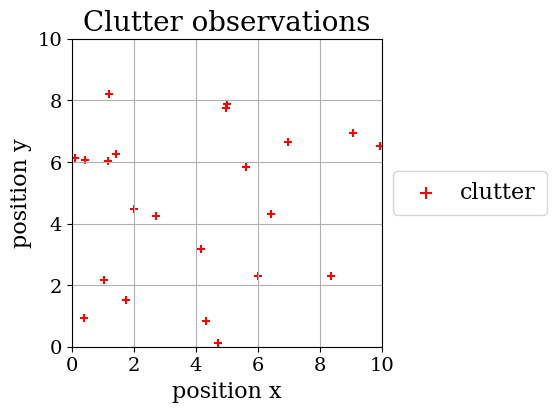

In [19]:
def generate_clutter(clutter_intensity: float, range_c: np.ndarray, dim: int) -> np.ndarray:
    num_clutter = np.random.poisson(clutter_intensity)
    return np.random.uniform(*np.diag(range_c), [num_clutter, dim])


clutter_intensity, range_c, dim = 15, np.array([[0, 10], [0, 10]]), 2

plt.figure(figsize=(4, 4))
clutter = generate_clutter(clutter_intensity, range_c, dim)
if clutter.size > 0:
    plt.scatter(clutter[:, 0], clutter[:, 1], marker="+", color="r", label="clutter")
plt.xlim(range_c[0])
plt.ylim(range_c[1])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Clutter observations")
plt.xlabel("position x")
plt.ylabel("position y")
plt.grid(True)
plt.show()

## Tracking



So, we're left with one issue before solving the SOT task. We have a track, and we're receiving sensor data, meaning measurements. However, we don't know if these measurements are from the object or just clutter.

What should we do? Let's consider the possibilities: the measurement is of the object, there's no measurement at all, or it's clutter.

<img src="https://raw.githubusercontent.com/kharitonov-ivan/multi-object-tracking-in-python/main/images/tutorial/hypotheses.drawio.svg" alt="drawing" width="300"/>

So, we're planning to devise something. Essentially, we aim to compute the likelihood of each hypothesis and make a decision based on that.

There are two possible outcomes:

1) It's a missed detection.

2) It's a detection, potentially clutter.


For the first outcome:
missdetection_ll = 1 - detection_proba

This is logical, as it relates to the measurement model.

For the second outcome:
log_likelihood = likelihood(state in track, measurement) + detection_proba/clutter_rate

Thus, we can calculate the missdetection likelihood, and for each measurement, assess the likelihood.

Then, we identify the maximum likelihood and decide our course of action. If it's a missed detection, we proceed with a prediction step. Otherwise, we update the state with the measurement having the highest likelihood.

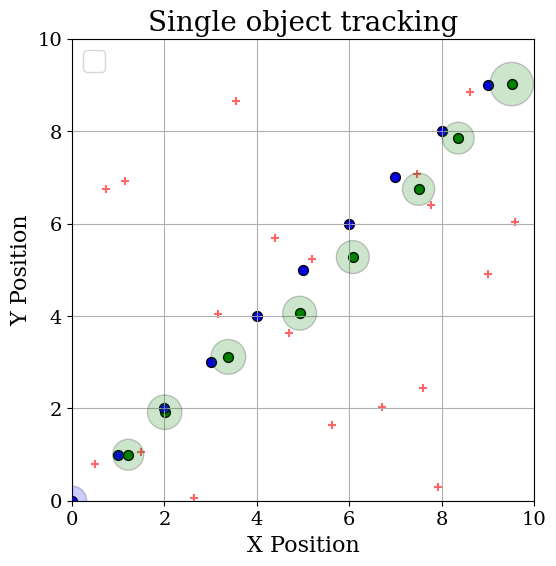

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from src.measurement_models import ConstantVelocityMeasurementModel
from src.common.state import Gaussian
from src.common.gaussian_density import GaussianDensity as gd

motion_model = ConstantVelocityMotionModel(random_state=42, sigma_q=0.1)
measurement_model = ConstantVelocityMeasurementModel(sigma_r=0.5)


def generate_noisy_measurement_sample(state, P_D, clutter_intensity, range_c, dim):
    observation = measurement_model.observe(state.x)
    observation = generate_missdetection(observation, P_D)
    clutter = generate_clutter(clutter_intensity, range_c, dim)

    # Combine observation with clutter
    measurements = []
    if observation is not None:
        measurements.append(observation[None, ...])
    if len(clutter) > 0:
        measurements.append(clutter)
    return np.concatenate(measurements)


# Generate trajectories and observations
timesteps: int = 10
detection_proba: float = 0.7
clutter_intensity: float = 10.0
clutter_area = np.array([[0, 10], [0, 10]])
true_trajectory: list[Gaussian] = generate_true_trajectory(motion_model, initial_state, timesteps, dt)
observations: list[np.ndarray] = [generate_noisy_measurement_sample(state, detection_proba, clutter_intensity, clutter_area, 2) for state in true_trajectory]


def nearest_neighbour_track_kf(measurements, current_state, P_D, intensity_c, dt):
    # Predict step
    state = predict(current_state, motion_model, dt)

    if len(measurements) == 0:
        return state  # No update if no measurements

    log_likelihoods = np.array([gd.predict_loglikelihood(state, m[None, ...], measurement_model) for m in measurements])
    w_detection = log_likelihoods + np.log(P_D / intensity_c)
    w_missdetection = np.log(1 - P_D)

    max_idx = np.argmax(w_detection)
    if w_detection[max_idx] > w_missdetection:
        return update(state, measurements[max_idx], measurement_model)
    return state  # Return predicted state if no measurement is selected


dt = 1
initial_state = Gaussian(np.array([0, 0, 1, 1]), np.eye(4) * 0.1)
current_state = initial_state
estimated_states = []
for i in range(timesteps):
    current_state = nearest_neighbour_track_kf(observations[i], current_state, detection_proba, clutter_intensity / np.prod(np.diff(clutter_area)), dt)
    estimated_states.append(current_state)


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Single object tracking")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.grid(True)
for true_state, obs, estimated_state in zip(true_trajectory, observations, estimated_states):
    true_state.plot(ax=ax)
    plt.scatter(obs[0], obs[1], color="red", alpha=0.6, marker="+")
    estimated_state.plot(ax, color="g")
ax.legend()
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.gca().set_aspect("equal")
plt.show()

In [34]:
np.log(0.3)

-1.2039728043259361

## Gating

<img src="https://raw.githubusercontent.com/kharitonov-ivan/multi-object-tracking-in-python/main/images/tutorial/gating.drawio.svg" alt="drawing" width="600"/>


Thus, the number of clutter points can be quite substantial. We can't consider all of them, so how do we filter? Perhaps by assessing the distance between our track and each individual measurement? However, our track is represented as a Gaussian, which provides insights into uncertainty via its covariance. We'd like to utilize this feature as well. Is there a specific distance measure between a Gaussian and a sample? Indeed, there is – it's called the Mahalanobis distance.

In [21]:
import numpy as np


def mahalanobis_distance(x, mu, sigma):
    diff = x - mu
    inv_sigma = np.linalg.inv(sigma)
    return np.sqrt(np.dot(np.dot(diff.T, inv_sigma), diff))


# Simulated object state (mean)
object_mean = np.array([2, 2])  # Example object position
object_covariance = np.array([[1, 0], [0, 1]])  # Covariance matrix for the object

true_measurement = np.array([2.1, 2.1])
distance = mahalanobis_distance(true_measurement, object_mean, object_covariance)
print(f"Mahalanobis Distance from true measurement to object: {distance:.2f}")

# Generate clutter points
np.random.seed(0)  # Seed for reproducibility
clutter_points = np.random.uniform(0, 5, (5, 2))  # 5 clutter points

# Calculate Mahalanobis distances for each clutter point
for i, point in enumerate(clutter_points):
    distance = mahalanobis_distance(point, object_mean, object_covariance)
    print(f"Mahalanobis Distance from clutter point {i} to object: {distance:.2f}")

Mahalanobis Distance from true measurement to object: 0.14
Mahalanobis Distance from clutter point 0 to object: 1.74
Mahalanobis Distance from clutter point 1 to object: 1.25
Mahalanobis Distance from clutter point 2 to object: 1.24
Mahalanobis Distance from clutter point 3 to object: 2.47
Mahalanobis Distance from clutter point 4 to object: 2.82


# N object tracking

Let's complicate the task a bit. Now, instead of tracking a single object, we are tracking multiple objects. These objects are always present, and their number, which we know, is constant. This involves tracking a known and fixed number of objects, where
�
n (the known number of objects) is both known and constant.

Compared to Single Object Tracking (SOT), we are faced with a new challenge - Data Association. In simple terms, where we previously only considered missdetection, clutter, and association with a single measurement, we now have multiple tracks. Therefore, we need to establish a good association between our tracks and the measurements.

<img src="https://raw.githubusercontent.com/kharitonov-ivan/multi-object-tracking-in-python/main/images/tutorial/da-simple.drawio.svg" alt="drawing" width="600"/>


So, let's consider an example - we have two tracks with states and measurements z1, z2, z3.

We can examine all the combinations:
s1-z1, s1-z2, s1-z3, s1-miss

s2-z1, s2-z2, s2-z3, s2-miss

Let's think, what can we do with this? We want to find the most plausible hypothesis that consists of events for each track. This can be achieved by reformulating the problem as a linear programming task.

### DA - data association

Continuing, we can list the likelihoods of all our hypotheses in a matrix and find the combination that yields the highest likelihood. This approach allows us to systematically evaluate each possible scenario and select the most probable one based on the computed likelihood values.

Assume:
n - number of objects
m - number of measurements

Creating cost matrix with n rows and n + m columns.

We fill left part with likelihood for each n object and each measurement.
Right part is diagonal, and represents missdetections. All likelihoods in log format.
$$ - log(0) = - \inf $$

Assignment matrix :
$$
A=\left[\begin{array}{cccc|cccc}
A^{1,1} & A^{1,2} & \ldots & A^{1, m} & A^{1, m+1} & 0 & \ldots & 0 \\
A^{2,1} & A^{2,2} & \ldots & A^{2, m} & 0 & A^{2, m+2} & \ldots & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\
A^{n, 1} & A^{n, 2} & \ldots & A^{n, m} & 0 & 0 & \ldots & A^{n, m+n}
\end{array}\right]
$$
    
We can solve it like linear sum asingment problem, and get most probable hypothesis.

# Multi object tracking

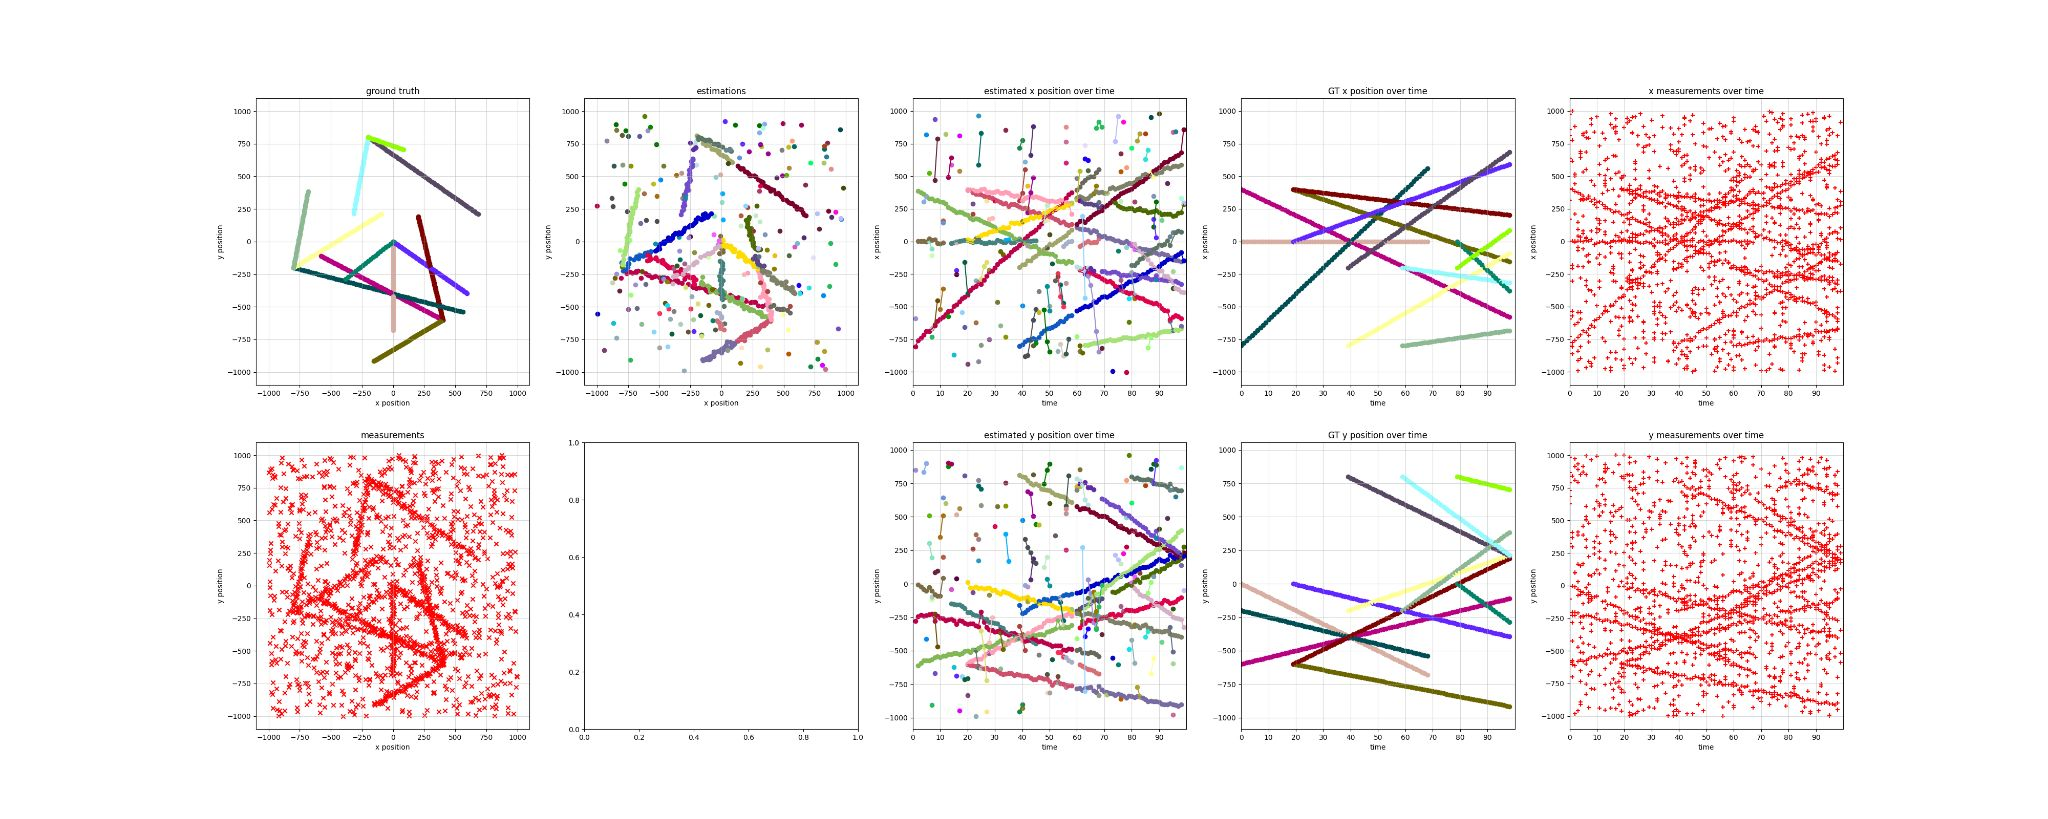

## Birth and death models

TBA

## Hypotheses tree

TBA

2) Linear sum assignment optimization techniques:
    * Hungarian
    * Murty
    * Gibbs sampling


# Appendix

### Probability Theory Primer:

- **PDF (Probability Density Function)**: Represents the distribution of a continuous random variable.
$$
f(x) \text{ is the PDF if for any } a \text{ and } b:
P(a \leq x \leq b) = \int_{a}^{b} f(x) \, dx
$$

- **Conditional Distributions**:
$$
\begin{aligned}
p(x, z) &= p(z | x) p(x) \\
p(z | x) &= \frac{p(x, z)}{p(x)}
\end{aligned}
$$

- **Example Gaussian PDF**:
$$
N ( x ; \mu , Q ) = \frac{1}{\sqrt{|2 \pi Q |}} \exp \left(-\frac{1}{2}( x - \mu )^{T} Q ^{-1}( x - \mu )\right)
$$

- **PMF (Probability Mass Function)**: Represents the distribution of a discrete random variable.

- **Law of Total Probability**:
$$
\begin{aligned}
p(z) &= \int p(x, z) \, dx \\
p(z) &= \int p(z | x) p(x) \, dx
\end{aligned}
$$

- **1st and 2nd Moments**:
$$
\begin{aligned}
E \{ x \} &= \int x p( x ) \, dx \\
\operatorname{Cov}\{ x \} &= E \left\{[ x - E \{ x \}][ x - E \{ x \}]^{T}\right\}
\end{aligned}
$$


### Bernoulli Distribution

The Bernoulli distribution is a spesial case of the binomial distribution, but for a single bernoulli trial only. It is the discrete probability distribution of a trial with 2 possible outcomes, either 1 or 0, with respective probability $p$ and $q = 1 - p$.

If $x$ is Bernoulli distributed with probability, $p \in[0,1]$, it takes the values
$$
x=\left\{\begin{array}{ll}
1 & \text { with probability } p, \\
0 & \text { with probability } 1-p .
\end{array}\right.
$$
where $k$ is the possible outcome, and $p$ and $q$ are the respective possibilities.

**Where it uses** Bernoulli distribution is used to model the objects distribution given that the object is either detected (k=1) or missdetected

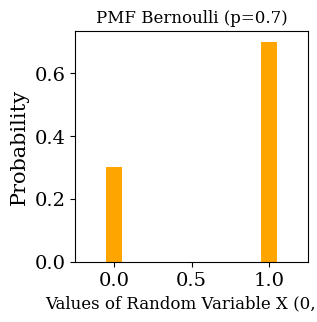

In [22]:
def bernoulli_pmf(p, x):
    """PMF for Bernoulli distribution."""
    return np.where(x == 1, p, 1 - p)


p = 0.7  # Bernoulli parameter
X = np.array([0, 1])  # Possible outcomes for Bernoulli distribution

plt.figure(figsize=(3, 3))
plt.xlim(-0.25, 1.25)
plt.bar(X, bernoulli_pmf(p, X), color="orange", width=0.1)
plt.title("PMF Bernoulli (p=0.7)", fontsize="12")
plt.xlabel("Values of Random Variable X (0, 1)", fontsize="12")
plt.ylabel("Probability", fontsize="15")
plt.show()

### Poisson Distribution

Discrete distribution
Poisson PMF with expected value $\lambda > 0$:

$$
f(k, \lambda) = e^{-\lambda} \frac{\lambda^L}{k!}
$$

$k$ - the number of events,

$\lambda$ - the average number of events occuring. Expeced number of events in interval $[a, b]$

It is useful to know that

$$\mathbb{E} [x] = Var [x] = \lambda$$


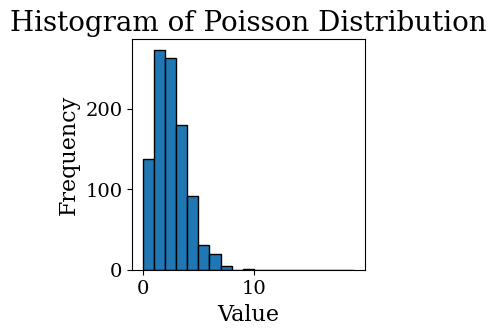

In [23]:
x = np.random.poisson(lam=2, size=1000)
plt.figure(figsize=(3, 3))
plt.hist(x, bins=range(0, 20), edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Poisson Distribution")
plt.show()

### binomial distribution

binomial trial is a random experiemnt with exaclty two posible outcomes.

binomial distribution can be describes of the discrete probability of how manu successes $k$ you get when you conduct $n$ independent bernoulli trials, each with a provaviltity $p$ to result in 1 or $q=1-p$ to resust in 0 with PMF

If $x$ is binomially distribution with parameters $p \in[0,1]$ and $j \in N$
$$
\operatorname{Pr}[x=i]=\left(\begin{array}{l}
n \\
k
\end{array}\right) p^{l}(1-p)^{n-k}
$$
where

factor is the binomial coeefficient, which is how many number of different ways k successes can come to be out of n trials.

$$
\left(\begin{array}{l}
n \\
k
\end{array}\right)=\frac{n !}{k !(n-k) !}
$$

It holds $$\mathbb{E} [x] = p n$$

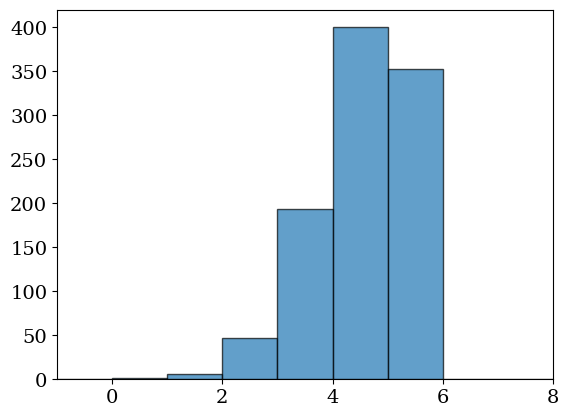

0.043999999999999595


In [24]:
x = np.random.binomial(n=5, p=0.8, size=1000)

plt.hist(x, bins=range(-1, 9), edgecolor="black", alpha=0.7)
plt.xlim(-1, 8)
plt.show()

print(x.mean() - 5 * 0.8)

#### References
* <a id="1">[1]</a> _Fontana, M., García-Fenández, Á. F., & Maskell, S. (2020, July). Bernoulli merging for the Poisson multi-Bernoulli mixture filter. In 2020 IEEE 23rd International Conference on Information Fusion (FUSION) (pp. 1-8). IEEE._
